In [43]:
import os
os.getcwd()

'c:\\Users\\nmishra\\Desktop\\lassa\\notebooks'

In [44]:
msa_depth = "192"  # Example model number

In [45]:
# Construct paths based on the model number
# to be updated with construct_path function from plotting notebook
# cif_directory = f"../taq/af3preds/step_{step_number}/extracted/"
main_folder = f"../josiah/af2preds/uncleaved/pdbs/msa{msa_depth}"
save_path = f"../josiah/af2preds/uncleaved/{msa_depth}_rmsf.png"
csv_path = f"../josiah/af2preds/uncleaved/{msa_depth}_rmsf.csv"

print(f"Working on MSA Depth {msa_depth}:")
# print(f"CIF directory: {cif_directory}")
print(f"PDB folder: {main_folder}")
print(f"Save path for image: {save_path}")

Working on MSA Depth 192:
PDB folder: ../josiah/af2preds/uncleaved/pdbs/msa192
Save path for image: ../josiah/af2preds/uncleaved/192_rmsf.png


In [46]:
# from Bio.PDB.MMCIFParser import MMCIFParser
# from Bio.PDB.PDBIO import PDBIO
# import os
# import glob


# def convert_cif_to_pdb(main_dir):
#     # Define the output directory for PDB files
#     output_dir = os.path.join(main_dir, "..", "pdbs")
#     os.makedirs(output_dir, exist_ok=True)

#     # Iterate over each subdirectory
#     for subdir in os.listdir(main_dir):
#         subdir_path = os.path.join(main_dir, subdir)

#         # Check if it's a directory
#         if os.path.isdir(subdir_path):
#             print(f"Processing directory: {subdir_path}")

#             # List all CIF files in the subdirectory
#             cif_files = glob.glob(os.path.join(subdir_path, "*.cif"))

#             # Convert each CIF file to PDB format
#             for cif_file in cif_files:
#                 try:
#                     # Parse CIF file
#                     parser = MMCIFParser()
#                     structure = parser.get_structure(
#                         os.path.basename(cif_file), cif_file
#                     )

#                     # Generate PDB file name in the output directory
#                     pdb_filename = (
#                         os.path.splitext(os.path.basename(cif_file))[0] + ".pdb"
#                     )
#                     pdb_file = os.path.join(output_dir, pdb_filename)

#                     # Save structure as PDB file
#                     pdb_io = PDBIO()
#                     pdb_io.set_structure(structure)
#                     pdb_io.save(pdb_file)

#                     print(f"Converted {cif_file} to {pdb_file}")
#                 except Exception as e:
#                     print(f"Error converting {cif_file}: {str(e)}")

# # add a check to see if the PDB folder is empty
# # if empty, then run the converter, else skip
# if not os.listdir(main_folder):
#     convert_cif_to_pdb(cif_directory)

In [47]:
# Calculate RMSF of ensemble of predictions for each subsampling condition

# Select atoms for RMSF calculations
rmsf_sel = "backbone"

import os
import glob
import re
from typing import List, Tuple, Union

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.analysis import pca, align, rms

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")


class LoadPredictions:
    def __init__(self, trajectory_files: List[str], topology_file: str) -> None:
        """
        Initialize the LoadTrajectory class with a list of trajectory files and a single topology file.

        :param trajectory_files: List of paths to trajectory files (.pdb)
        :param topology_file: Path to the topology file (.pdb)
        """
        self.trajectory_files = trajectory_files
        self.topology_file = topology_file
        self.universe: Union[None, mda.Universe] = None

    def load(self) -> None:
        """
        Load the trajectories and the topology file into an MDAnalysis Universe.
        """
        try:
            self.universe = mda.Universe(
                self.topology_file, self.trajectory_files, dt=1
            )
        except Exception as e:
            print(f"An error occurred while loading the files: {e}")

    def get_universe(self) -> Union[mda.Universe, None]:
        """
        Return the MDAnalysis Universe object.
        """
        if self.universe is not None:
            return self.universe
        else:
            print("Universe not loaded. Call the 'load' method first.")
            return None


def atoi(text: str) -> Union[int, str]:
    return int(text) if text.isdigit() else text


def natural_keys(text: str) -> List[Union[int, str]]:
    """
    Helper function for natural sorting (human sorting).
    """
    return [atoi(c) for c in re.split(r"(\d+)", text)]


def sorted_natural_glob(pattern: str, sort: bool = False) -> List[str]:
    """
    Perform a glob search and return a list of file paths.
    Sort the list naturally by file name if sort is True.

    :param pattern: Glob pattern to search for.
    :param sort: Boolean indicating whether to sort the results.
    :return: List of file paths, sorted if sort is True.
    """
    file_paths: List[str] = glob.glob(pattern)
    if sort:
        file_paths.sort(key=lambda x: natural_keys(x))
    return file_paths


def ensembleRMSF(
    base_path: str, analysis_range: str, sort: bool = True
) -> Tuple[List[rms.RMSF], mda.AtomGroup]:
    pdb_files = sorted_natural_glob(os.path.join(base_path, "*.pdb"), sort)
    if not pdb_files:
        print(f"No PDB files found in {base_path}")
        return None, None

    topology_file = pdb_files[0]

    u_getter = LoadPredictions(pdb_files, topology_file)
    u_getter.load()
    u = u_getter.get_universe()
    if u is None:
        return None, None

    average = align.AverageStructure(u, u, select=analysis_range, ref_frame=0).run()
    ref = average.results.universe
    aligner = align.AlignTraj(u, ref, select=analysis_range, in_memory=True).run()
    c_alphas = u.select_atoms(analysis_range)
    R = rms.RMSF(c_alphas).run()
    return R, c_alphas

# Initialize the results list
rmsf_results: List[Tuple[str, rms.RMSF]] = []

In [48]:
R, c_alphas = ensembleRMSF(main_folder, rmsf_sel)

In [49]:
first_plotted_residue = min(c_alphas.resids)  # @param {type:"string"}
print(first_plotted_residue)
last_plotted_residue = max(c_alphas.resids)  # @param {type:"string"}
print(last_plotted_residue)

1
370


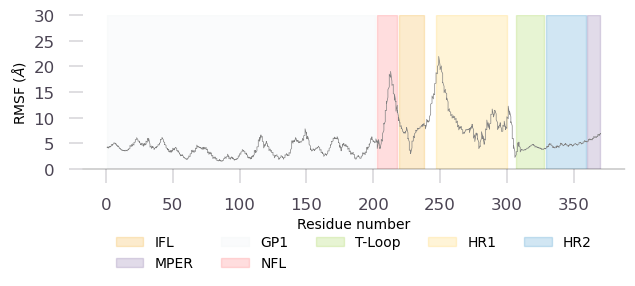

In [50]:
import matplotlib.pyplot as plt
import numpy as np


def plot_rmsf(c_alphas, rmsf_results, save_path):
    fig_size = (7, 2)
    plt.figure(figsize=fig_size)

    plt.plot(c_alphas.resids, rmsf_results.rmsf, color="gray", linewidth=0.5)
    plt.xlabel("Residue number")
    plt.ylabel("RMSF ($\AA$)")



    # Define regions and their properties
    regions = [
        {"start": 1, "end": 201, "color": "#e8eef1", "label": "GP1"},
        {"start": 203, "end": 218, "color": "#ff595e", "label": "NFL"},
        {"start": 219, "end": 238, "color": "#f29f05", "label": "IFL"},
        {"start": 247, "end": 300, "color": "#ffca3a", "label": "HR1"},
        {"start": 307, "end": 328, "color": "#8ac926", "label": "T-Loop"},
        {"start": 329, "end": 359, "color": "#1982c4", "label": "HR2"},
        {"start": 360, "end": 370, "color": "#6a4c93", "label": "MPER"},
    ]

    # Plot regions
    for region in regions:
        plt.axvspan(
            region["start"],
            region["end"],
            zorder=0,
            alpha=0.2,
            color=region["color"],
            label=region["label"],
        )

    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(set(labels))  # Get unique labels
    plt.legend(
        [handles[labels.index(label)] for label in unique_labels],
        unique_labels,
        bbox_to_anchor=(0.5, -0.35),
        loc="upper center",
        ncol=5,
        frameon=False,
    )

    plt.ylim(0, 30)
    plt.yticks(np.arange(0, 31, 5))
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_linewidth(0.25)

    ax.tick_params(
        width=0.25,
        length=10,
        color="#4B4453",
        pad=10,
        labelsize=12,
        labelcolor="#4B4453",
    )

    plt.savefig(save_path, dpi=600, bbox_inches="tight")


# Example usage:
# Assuming c_alphas and R.results are defined elsewhere
# c_alphas = ...
# R.results = ...
# save_path = "path/to/save/figure.png"

# Call the function to generate the plot
plot_rmsf(c_alphas, R.results, save_path)

In [51]:
# Save data to CSV
data = {"Residue_number": c_alphas.resids, "RMSF": R.results.rmsf}
df = pd.DataFrame(data)
df.to_csv(csv_path, index=False)